# Basic imports

In [2]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensor Flow Version: 2.8.0
Keras Version: 2.8.0

Python 3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import master_functions as mf

In [2]:
df_all = pd.read_csv('main_df.csv')
learning_df = pd.read_csv('learning_df.tsv', sep='\t')

# Keras MLP

## Simple MLP

In [3]:
X_learning = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_learning = learning_df['y']
groups_learning = learning_df['group_code'].to_numpy()

In [4]:
from sklearn.model_selection import GridSearchCV, cross_validate, LeaveOneGroupOut
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=9, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

# create the model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)

pipe = Pipeline([
    ('normalize', Normalizer()),
    ('keras_ann', model)
])
logo = LeaveOneGroupOut()

C:\Users\User\AppData\Local\Temp/ipykernel_15228/1163313088.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)


In [ ]:
# evaluate model
results_dnn = cross_validate(pipe, X_learning.values, y_learning, scoring='f1', 
        cv=logo, groups=groups_learning, n_jobs=1, return_estimator=True, verbose=10)

In [ ]:
from joblib import dump
dump(results_dnn, './results.joblib')

### Save the model

In [21]:
type(results_dnn['estimator'][0].named_steps)

sklearn.utils.Bunch

In [27]:
for i, pipel in enumerate(results_dnn['estimator']):
    pipel.named_steps['keras_ann'].model.save(f'simple_dnn_models/keras_models/model_{i}.h5')
    pipel.named_steps['keras_ann'].model = None
    dump(pipel, f'simple_dnn_models/sklearn_pipeline/sk_pipe_{i}.pkl')
dump(results_dnn, 'simple_dnn_models/results_dnn_master.joblib')

['simple_dnn_models/results_dnn_master.joblib']

In [9]:
dnn_preds = mf.get_probabilities(X_learning.columns, results_dnn, df_all, normalize=True)

In [10]:
dnn_preds.head()

,0,1
0,0.199300,0.800700
1,0.196011,0.803989
2,0.203598,0.796402
3,0.207186,0.792814
4,0.203718,0.796282


In [14]:
df_dnn = pd.concat([df_all, dnn_preds], axis=1)

In [15]:
df_dnn.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.199300,0.800700
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.196011,0.803989
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.203598,0.796402
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.207186,0.792814
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.203718,0.796282


In [16]:
df_dnn.to_csv('df_dnn.tsv', sep='\t')

### Simple MLP - visualisation

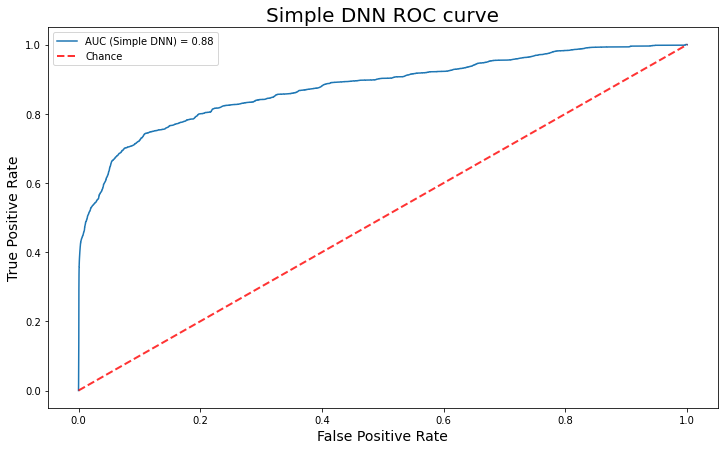

In [17]:
mf.draw_rocs([df_dnn], ['Simple DNN'], 'Simple DNN ROC curve')

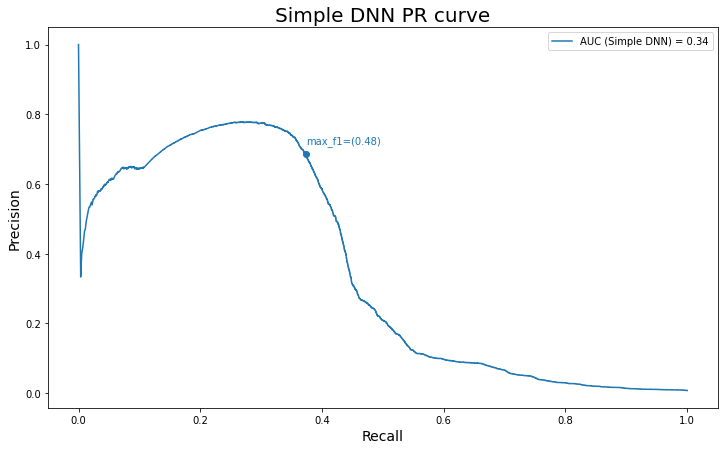

In [25]:
mf.draw_precision_recall_curve([df_dnn], ['Simple DNN'], 'Simple DNN PR curve')

In [5]:
df_dnn = pd.read_csv('df_dnn.tsv', sep='\t')

In [6]:
mf.get_correct_preds_percentages(df_dnn, mf.load_in_taxonomy_json(), 'Simple DNN', report=True)

Simple DNN - num of preds with highest prob: 913, mean = 1.11


,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
Simple DNN,38.170732,49.02439,59.756098,65.243902,73.292683,81.341463,100.0


## MLP with early stopping, top_k_categorical_accuracy

In [3]:
X_learning = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_learning = learning_df['y']
groups_learning = learning_df['group_code'].to_numpy()

In [7]:
from sklearn.model_selection import GridSearchCV, cross_validate, LeaveOneGroupOut
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

def create_model():
    model = Sequential()
    model.add(Dense(100, input_dim=9, activation='relu'))
    model.add(Dense(75, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['top_k_categorical_accuracy'])
    return model

es = EarlyStopping(monitor='loss', patience=3, verbose=1)
# create the model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)

pipe = Pipeline([
    ('normalize', MinMaxScaler()),
    # ('standardize', StandardScaler()),
    ('keras_ann', model)
])
logo = LeaveOneGroupOut()
additional_params = {'keras_ann__callbacks': [es]}

C:\Users\User\AppData\Local\Temp\ipykernel_13700\1863841645.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)


In [ ]:
results_dnn_2 = cross_validate(pipe, X_learning.values, y_learning, scoring='f1', 
        cv=logo, groups=groups_learning, n_jobs=1, return_estimator=True, 
        verbose=10, fit_params=additional_params)

### Save the model

In [ ]:
for i, pipel in enumerate(results_dnn_2['estimator']):
    pipel.named_steps['keras_ann'].model.save(f'mlp2/keras_models/model_{i}.h5')
    pipel.named_steps['keras_ann'].model = None


In [11]:
from joblib import dump
dump(results_dnn_2, 'mlp2/results_dnn_master.joblib')

['mlp2/results_dnn_master.joblib']

In [15]:
for i, pipel in enumerate(results_dnn_2['estimator']):
    pipel.named_steps['keras_ann'].model = keras.models.load_model(f'mlp2/keras_models/model_{i}.h5')

In [16]:
df_dnn_2 = pd.concat([df_all, mf.get_probabilities(X_learning.columns, results_dnn_2, df_all, normalize=True)], axis=1)

In [17]:
df_dnn_2.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.975226,0.024774
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.645512,0.354488
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.965322,0.034678
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.978861,0.021139
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.964498,0.035502


### Visualizations

In [18]:
X_main = df_all.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_main = df_all['y']
groups_main = df_all['group_code'].to_numpy()

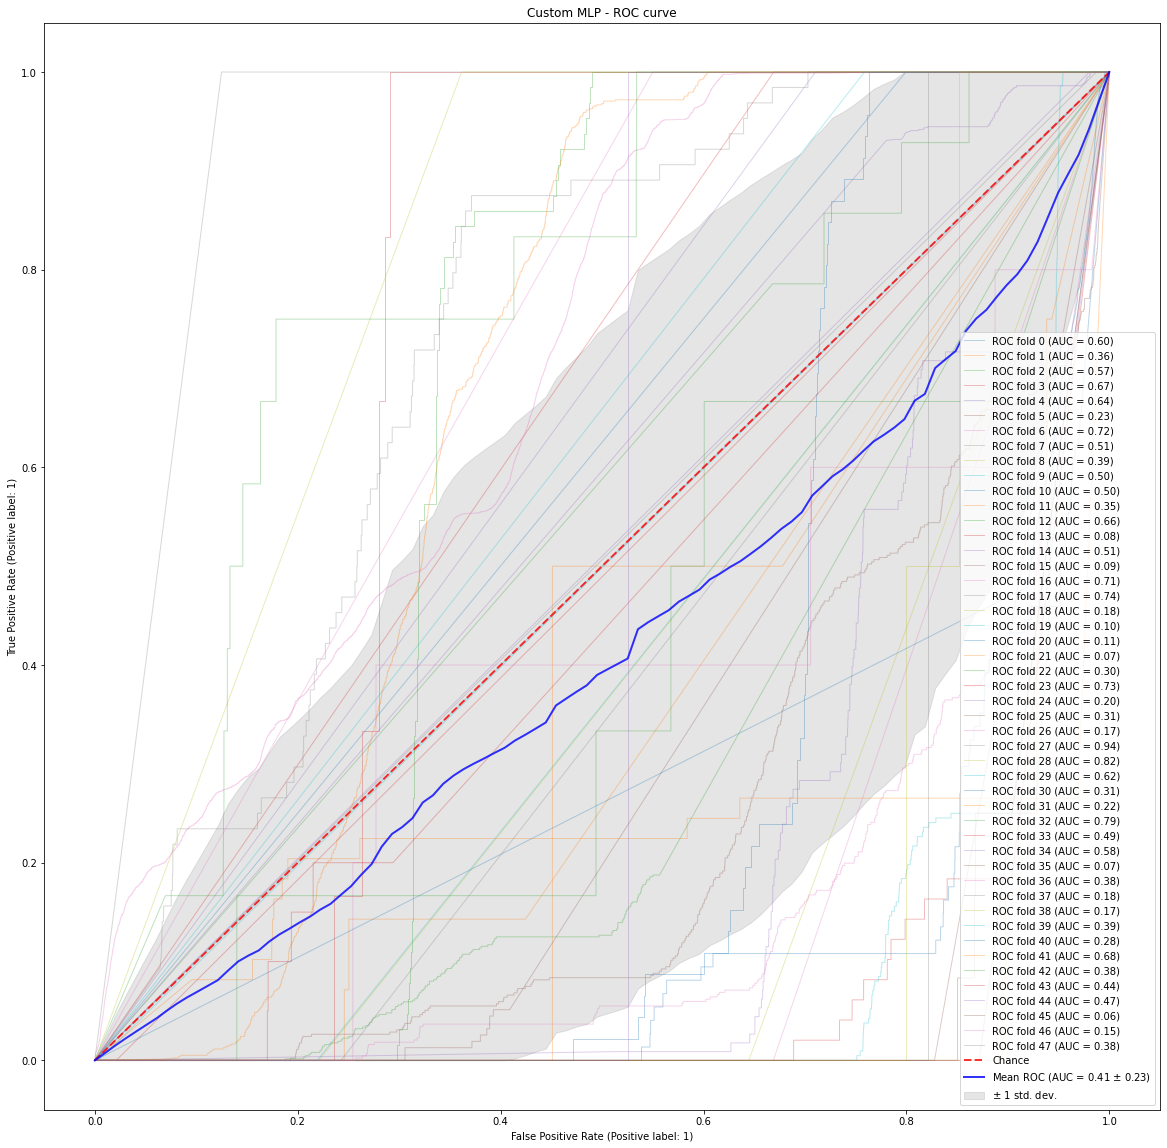

In [19]:
mf.draw_roc_cv(df_dnn_2, logo, X_main, y_main, groups_main, 'Custom MLP')

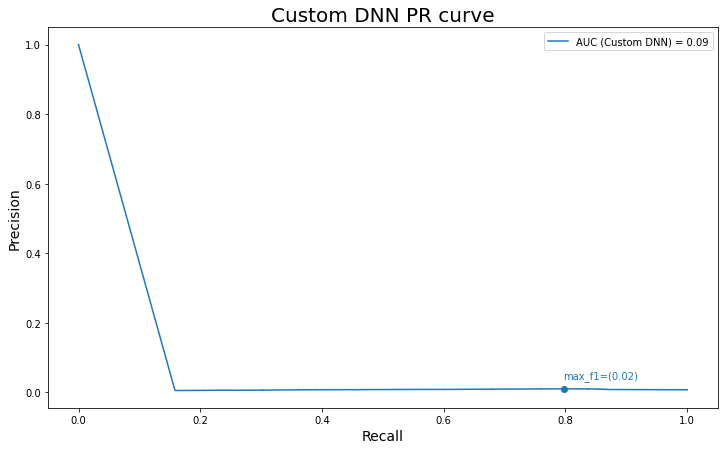

In [20]:
mf.draw_precision_recall_curve([df_dnn_2], ['Custom DNN'], 'Custom DNN PR curve')

In [24]:
orgs = mf.load_in_taxonomy_json()

In [26]:
mf.get_correct_preds_percentages(df_dnn_2, orgs, 'Custom DNN', report=True)

Custom DNN sizes of groups: (497104, 3)


,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
Custom DNN,0.365854,1.341463,8.170732,9.512195,17.317073,34.146341,100.0


# Custom DNN 3

## MLP with:
1. early stopping
2. batch normalization 
3. ensambling (neuron dropout)
4. custom metric (F1)
5. weights constraints

In [5]:
X_learning = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_learning = learning_df['y']
groups_learning = learning_df['group_code'].to_numpy()

In [9]:
from sklearn.model_selection import GridSearchCV, cross_validate, LeaveOneGroupOut
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from keras import backend as K
from keras.constraints import maxnorm

# custom metric functions definitions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# definition of model creating function
def create_model():
    model = Sequential()
    model.add(Dense(100, input_dim=9, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(75, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m])
    return model

# add early stopping
es = EarlyStopping(monitor='loss', patience=3, verbose=1)


# create the model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)

# define sklearn elements
pipe = Pipeline([
    ('normalize', Normalizer()),
    ('keras_ann', model)
])
logo = LeaveOneGroupOut()
additional_params = {'keras_ann__callbacks': [es]}

C:\Users\User\AppData\Local\Temp/ipykernel_13600/2958780017.py:42: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)


In [ ]:
results_dnn_3 = cross_validate(pipe, X_learning.values, y_learning, scoring='f1', 
        cv=logo, groups=groups_learning, n_jobs=1, return_estimator=True, 
        verbose=10, fit_params=additional_params)

### Save the model

In [12]:
from joblib import dump
for i, pipel in enumerate(results_dnn_3['estimator']):
    pipel.named_steps['keras_ann'].model.save(f'mlp3/keras_models/model_{i}.h5')
    pipel.named_steps['keras_ann'].model = None
dump(results_dnn_3, 'mlp3/results_dnn_master.joblib')

['mlp3/results_dnn_master.joblib']

### Visualisation

Load models back in

In [17]:
for i, pipel in enumerate(results_dnn_3['estimator']):
    pipel.named_steps['keras_ann'].model = keras.models.load_model(f'mlp3/keras_models/model_{i}.h5',  
            compile=False) # compile = False for custom F1 metric

In [18]:
df_dnn_3 = pd.concat([df_all, mf.get_probabilities(X_learning.columns, results_dnn_3, df_all, normalize=True)], axis=1)

In [31]:
df_dnn_3.to_csv('df_custom_dnn.tsv', sep='\t')

In [21]:
df_dnn_3.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.239065,0.760935
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.244871,0.755129
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.247091,0.752909
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.248443,0.751557
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.247151,0.752849


In [19]:
X_main = df_all.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_main = df_all['y']
groups_main = df_all['group_code'].to_numpy()

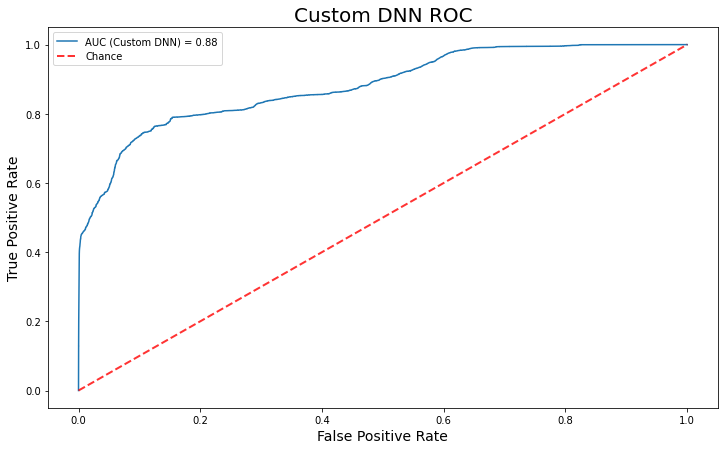

In [22]:
mf.draw_rocs(dfs=[
    df_dnn_3
    ],
    names=[
        'Custom DNN'
    ],
    plot_name='Custom DNN ROC')

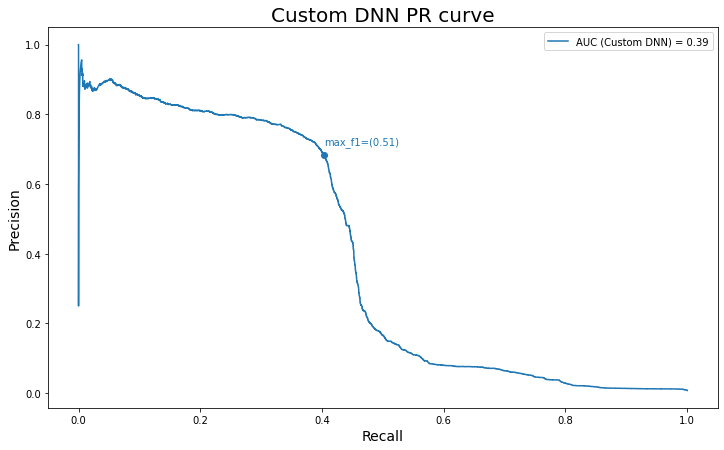

In [23]:
mf.draw_precision_recall_curve(dfs=[
    df_dnn_3
    ],
    names=[
        'Custom DNN'
    ],
    plot_name='Custom DNN PR curve')

In [27]:
orgs = mf.load_in_taxonomy_json()

In [30]:
mf.get_correct_preds_percentages(df_dnn_3, orgs, 'Custom DNN', report=True)

Custom DNN - num of preds with highest prob: 846, mean = 1.03


,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
Custom DNN,46.95122,60.731707,71.341463,73.780488,80.853659,85.243902,100.0


# Custom DNN 4

## Same as before, but created on top 4 features with highest corr to label

In [32]:
corrs = X_main.corrwith(df_all['y']).abs().sort_values(ascending=False)
feats = list(corrs.index[0:4])
X_learning = learning_df[feats]
y_learning = learning_df['y']
groups_learning = learning_df['group_code'].to_numpy()

In [36]:
X_learning.columns

Index(['k25', 'blastn', 'crisprdetect-2mismatch', 'piler-2mismatch'], dtype='object')

In [41]:
X_learning.groupby('piler-2mismatch').size().sort_values(ascending=False)

piler-2mismatch
0.0     33092
1.0       210
2.0       102
3.0        67
4.0        23
5.0        14
7.0         2
11.0        2
9.0         1
13.0        1
dtype: int64

In [45]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.constraints import maxnorm

# custom metric functions definitions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# definition of model creating function
def create_model():
    model = Sequential()
    model.add(Dense(100, input_dim=4, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(75, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m])
    return model

# add early stopping
es = EarlyStopping(monitor='loss', patience=3, verbose=1)

# create the model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)

# define sklearn elements
pipe = Pipeline([
    ('normalize', Normalizer()),
    ('keras_ann', model)
])
logo = LeaveOneGroupOut()
additional_params = {'keras_ann__callbacks': [es]}

C:\Users\User\AppData\Local\Temp/ipykernel_13600/3085550026.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=10)


In [ ]:
results_dnn_4 = cross_validate(pipe, X_learning.values, y_learning, scoring='f1', 
        cv=logo, groups=groups_learning, n_jobs=1, return_estimator=True, 
        verbose=10, fit_params=additional_params)

### Save the model

In [47]:
from joblib import dump
for i, pipel in enumerate(results_dnn_4['estimator']):
    pipel.named_steps['keras_ann'].model.save(f'mlp4/keras_models/model_{i}.h5')
    pipel.named_steps['keras_ann'].model = None
dump(results_dnn_4, 'mlp4/results_dnn_master.joblib')

['mlp4/results_dnn_master.joblib']

### Visualisation

Load models back in

In [48]:
for i, pipel in enumerate(results_dnn_4['estimator']):
    pipel.named_steps['keras_ann'].model = keras.models.load_model(f'mlp4/keras_models/model_{i}.h5',  
            compile=False) # compile = False for custom F1 metric

In [49]:
df_dnn_4 = pd.concat([df_all, mf.get_probabilities(X_learning.columns, results_dnn_4, df_all, normalize=True)], axis=1)

In [51]:
df_dnn_4.to_csv('df_custom_dnn_small.tsv', sep='\t')

In [52]:
df_dnn_4.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.294867,0.705133
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.294867,0.705133
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.294867,0.705133
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.294867,0.705133
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.294867,0.705133


In [53]:
X_main = df_all.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
y_main = df_all['y']
groups_main = df_all['group_code'].to_numpy()

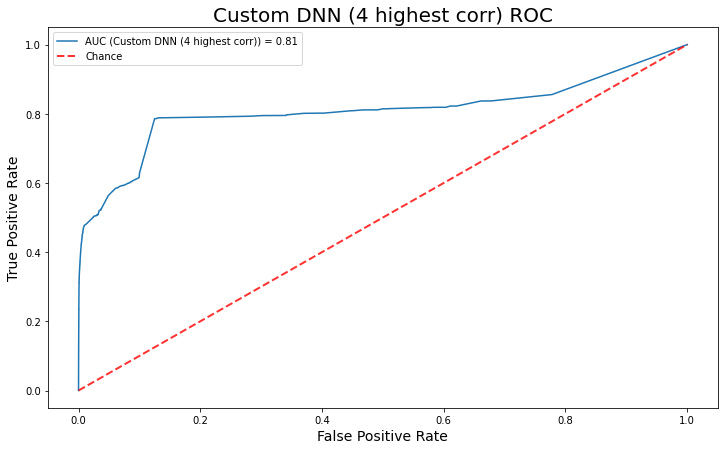

In [54]:
mf.draw_rocs(dfs=[
    df_dnn_4
    ],
    names=[
        'Custom DNN (4 highest corr)'
    ],
    plot_name='Custom DNN (4 highest corr) ROC')

d:\programming\ML_bacteriophage_host_predicting\master_functions.py:150: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = np.divide(2*recall*precision, recall+precision)


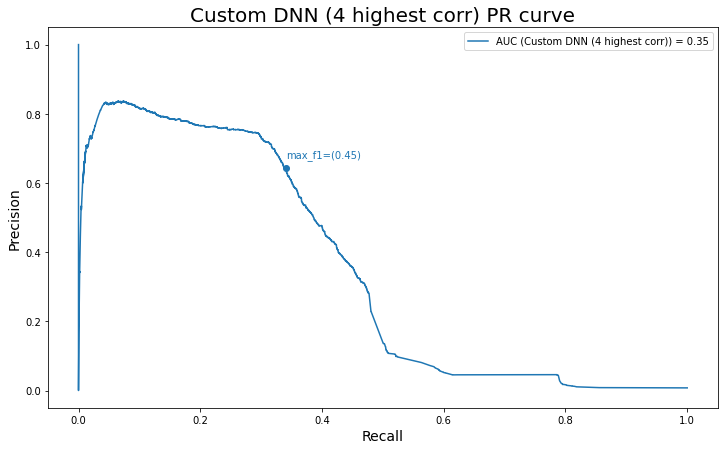

In [55]:
mf.draw_precision_recall_curve(dfs=[
    df_dnn_4
    ],
    names=[
        'Custom DNN (4 highest corr)'
    ],
    plot_name='Custom DNN (4 highest corr) PR curve')

In [56]:
orgs = mf.load_in_taxonomy_json()

In [57]:
mf.get_correct_preds_percentages(df_dnn_4, orgs, 'Custom DNN small', report=True)

Custom DNN small - num of preds with highest prob: 4906, mean = 5.98


,species_correct,genus_correct,family_correct,order_correct,class_correct,phylum_correct,superkingdom_correct
Custom DNN small,38.902439,46.95122,54.756098,58.292683,67.682927,78.902439,100.0
